# Chainerで回帰

## 必要なモジュールの読み込み

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df.tail()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


## 入力変数と教師データに分割

In [24]:
#df.iloc[行,列]
x = df.iloc[:,:-1].values.astype('f')
t = df.iloc[:,-1].values.astype('f')

In [20]:
x.dtype

dtype('float32')

In [21]:
t.dtype

dtype('float32')

In [22]:
x.shape

(506, 13)

In [23]:
#教師データのサイズ
t.shape

(506,)

In [25]:
len(t)

506

In [26]:
t = t.reshape(len(t),1)

In [27]:
t.shape

(506, 1)

# データセットの準備

In [28]:
dataset = list(zip(x,t))

## 訓練データと検証データの分割

In [29]:
import chainer
import chainer.functions as F
import chainer.links as L

In [31]:
n_train = int(len(dataset) * 0.7)
n_train

354

In [32]:
train, test = chainer.datasets.split_dataset_random(dataset,n_train,seed=0)

In [33]:
len(train)

354

In [34]:
len(test)

152

# モデルの定義

### L.Classifierを使う場合

In [59]:
#13->5->1
class NN(chainer.Chain):
    #mモデルの構造
    def __init__(self,n_mid_units=5,n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units)
            self.fc2 = L.Linear(None,n_out)
    #順伝播
    def __call__(self,x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [60]:
np.random.seed(0)
#インスタンス化
nn = NN()

In [61]:
#変更箇所（回帰問題）
model = L.Classifier(nn,lossfun=F.mean_squared_error)
model.compute_accuracy = False

### 学習用のモデルを自前で書く場合
- `__init__`: モデルで使用するリンクの宣言
- `__call__`: 損失関数の宣言
- `predictor`: 順伝播の宣言

In [44]:
# #13->5->1
# class NN(chainer.Chain):
#     #mモデルの構造
#     def __init__(self,n_mid_units=5,n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None,n_mid_units)
#             self.fc2 = L.Linear(None,n_out)
#     #損失関数
#     def __call__(self,x,t):
#         #予測値の計算（順伝播）
#         y = self.predictor(x)
#         loss = F.mean_squared_error(t,y)
#         chainer.report({'loss':loss},self)
#         return loss
#     #順伝播
#     def predictor(self,x):
#         h = self.fc1(x)
#         h = F.relu(h)
#         h = self.fc2(h)
#         return h

In [45]:
# np.random.seed(0)
# model = NN()

## 学習に必要な準備

### Optimizerの設定

In [62]:
optimizer = chainer.optimizers.SGD() #確率的勾配降下法

In [63]:
optimizer.setup(model)

### Iteratorの設定
ミニバッチ学習

In [64]:
batchsize = 10

In [65]:
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

### Updaterの設定
使用するデバイスの設定
- CPU: -1
- GPU: 0 （割り当てID）

In [66]:
from chainer import training

In [67]:
updater = training.StandardUpdater(train_iter,optimizer,device=-1)

### TrainerとExtensionsの設定

In [68]:
from chainer.training import extensions

In [69]:
#エポック数
epoch = 50

In [70]:
#Trainerの宣言
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/housing')

#検証データで評価
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))

trainer.extend(extensions.LogReport(trigger=(1,'epoch')))

#1エポック毎（trigger）にtrainデータに対するlossとtestデータに対するloss、経過時間を出力します。
trainer.extend(
    extensions.PrintReport(['epoch','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))

## 学習の実行

In [71]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           2.96434e+08  1.04874e+06           0.0995172     
2           572259      255203                0.19538       
3           136911      59814.5               0.332427      
4           32620.6     14627.9               0.489798      
5           7952.06     3666.92               0.631439      
6           1964.45     941.861               0.774366      
7           528.449     306.799               0.907968      
8           184.278     147.592               1.07125       
9           104.365     108.861               1.22311       
10          84.1915     99.445                1.37484       
11          80.6581     96.3452               1.54451       
12          77.2385     95.7064               1.71576       
13          78.0365     95.3591               1.87651       
14          77.8604     95.2921               2.0302        
15          79.0005     95.2218               2.54349       
16          78.815      9

## 結果の確認

In [72]:
import json

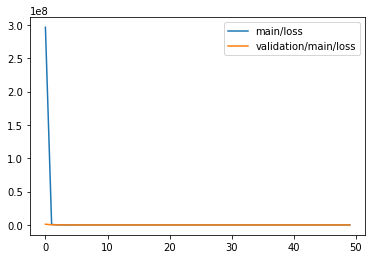

In [73]:
with open('result/housing/log') as f:
    logs = json.load(f)
results = pd.DataFrame(logs)
results[['main/loss','validation/main/loss']].plot()

## 試行錯誤

In [75]:
#13->5->1
class NN(chainer.Chain):
    #mモデルの構造
    def __init__(self,n_mid_units=5,n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None,n_mid_units)
            self.fc2 = L.Linear(None,n_out)
            #Batch Normalization
            self.bn = L.BatchNormalization(13) #追記
    #順伝播
    def __call__(self,x):
        h = self.bn(x) #追記
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [81]:
np.random.seed(1)
nn = NN()
#変更箇所（回帰問題）
model = L.Classifier(nn,lossfun=F.mean_squared_error)
model.compute_accuracy = False

#optimizer = chainer.optimizers.SGD() #確率的勾配降下法
optimizer = chainer.optimizers.Adam() #とりあえずAdam
optimizer.setup(model)

batchsize = 10
train_iter = chainer.iterators.SerialIterator(train,batchsize)
test_iter = chainer.iterators.SerialIterator(test,batchsize,repeat=False,shuffle=False)

updater = training.StandardUpdater(train_iter,optimizer,device=-1)
epoch = 500
trainer = training.Trainer(updater,(epoch,'epoch'),out='result/housing')
trainer.extend(extensions.Evaluator(test_iter,model,device=-1))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))
trainer.extend(
    extensions.PrintReport(['epoch','main/loss','validation/main/loss','elapsed_time']),
    trigger=(1,'epoch'))
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           574.456     606.874               0.145987      
2           568.64      594.614               0.329859      
3           553.34      582.394               0.537772      
4           535.864     562.167               0.71829       
5           518.372     537.055               0.946288      
6           491.861     500.139               1.21243       
7           445.126     451.904               1.44409       
8           406.566     407.034               1.89645       
9           366.781     358.368               2.16419       
10          305.543     306.151               2.51451       
11          258.991     249.517               2.8516        
12          218.156     200.515               3.09793       
13          188.214     167.862               3.43506       
14          161.046     158.526               3.74358       
15          133.699     122.494               4.08907       
16          122.198     12

135         31.2265     22.6392               44.2456       
136         28.0762     21.8341               44.5106       
137         30.7836     22.9254               44.8544       
138         29.7594     22.7738               45.1403       
139         31.171      23.594                45.4476       
140         24.5306     21.7579               45.7349       
141         29.6288     21.688                45.9956       
142         29.6742     22.4417               46.2123       
143         28.6583     22.7723               46.5232       
144         28.7753     23.048                46.7571       
145         28.9797     20.5511               46.9686       
146         25.2886     22.5326               47.1871       
147         30.3889     21.8348               47.4827       
148         30.722      21.9784               47.7591       
149         25.1985     21.5681               48.0351       
150         26.9938     21.0437               48.2917       
151         28.7468     

270         26.4264     18.7596               94.0053       
271         27.0275     20.0155               95.2911       
272         24.1762     18.8343               95.5684       
273         26.4571     18.1408               95.8488       
274         24.9655     19.6093               96.1078       
275         25.1412     18.3746               96.4294       
276         25.2123     17.3443               96.8213       
277         22.4078     18.7117               97.0956       
278         23.595      18.4996               97.4224       
279         26.6222     18.3656               97.8258       
280         26.8827     18.2551               98.3074       
281         27.443      17.6169               98.8133       
282         27.8384     17.6175               99.2547       
283         27.1348     19.3275               99.7189       
284         25.7768     17.0407               100.2         
285         28.6116     17.2272               100.689       
286         23.4204     

405         25.886      16.0888               155.717       
406         24.9674     15.5416               156.097       
407         23.7195     16.0031               156.549       
408         26.0675     14.9525               157.016       
409         27.6546     17.2553               157.378       
410         22.9659     16.4457               157.747       
411         23.8782     16.0414               158.187       
412         25.6816     16.481                158.631       
413         24.2615     14.9951               159.02        
414         25.7948     17.5176               159.393       
415         23.4147     15.1961               159.729       
416         23.9065     15.3327               160.047       
417         23.6503     16.3657               160.274       
418         26.131      15.8162               160.488       
419         23.9858     16.0464               160.866       
420         25.7426     15.3796               161.438       
421         23.6734     

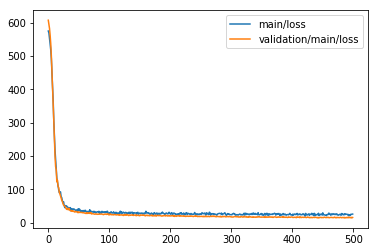

In [82]:
with open('result/housing/log') as f:
    logs = json.load(f)
results = pd.DataFrame(logs)
results[['main/loss','validation/main/loss']].plot()

In [83]:
np.sqrt(results['validation/main/loss'].values[-1])

3.9218045015571925